# FAIM SDK Example: FlowState Forecasting with Sunspots Dataset

This notebook demonstrates how to use the FAIM SDK to forecast time-series data using the FlowState model.

**Dataset**: Sunspots - Annual sunspot activity observations (1700-2008)

## 1. Setup and Installation

In [86]:
# Install dependencies if needed
# !pip install numpy pandas matplotlib statsmodels

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from faim_client.models import ModelName

# Import FAIM SDK
from faim_sdk import FlowStateForecastRequest, ForecastClient

## 2. Load Sunspots Dataset

The Sunspots dataset is built into statsmodels - no downloads needed!

In [88]:
# Load Sunspots dataset from statsmodels
import statsmodels.api as sm

# Load the dataset
sunspots_data = sm.datasets.sunspots.load_pandas()
df = sunspots_data.data

print("✓ Dataset loaded successfully")
print("  Dataset: Yearly sunspots (1700-2008)")
print(f"  Shape: {df.shape}")
print("\nDataset preview:")
print(df.head())

# Display basic info
print(f"\nColumns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")

✓ Dataset loaded successfully
  Dataset: Yearly sunspots (1700-2008)
  Shape: (309, 2)

Dataset preview:
     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0

Columns: ['YEAR', 'SUNACTIVITY']
Data types:
YEAR           float64
SUNACTIVITY    float64
dtype: object


In [89]:
df.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [90]:
# Inspect the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (309, 2)
Columns: ['YEAR', 'SUNACTIVITY']

Basic statistics:
              YEAR  SUNACTIVITY
count   309.000000   309.000000
mean   1854.000000    49.752104
std      89.344838    40.452595
min    1700.000000     0.000000
25%    1777.000000    16.000000
50%    1854.000000    40.000000
75%    1931.000000    69.800000
max    2008.000000   190.200000


## 3. Data Preprocessing

Time series length: 309
Value range: [0.0, 190.2]
Period: 1700-2008 (annual observations)


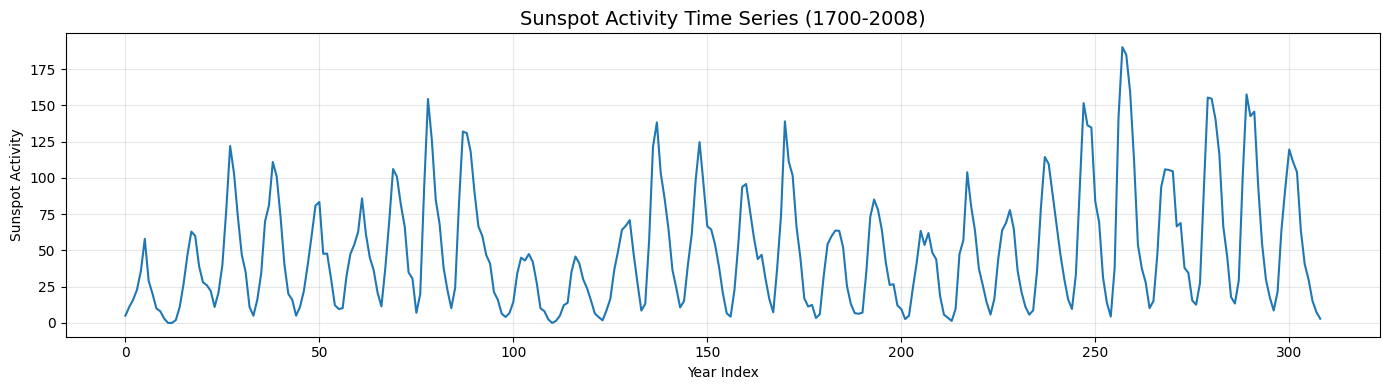

In [91]:
# Extract sunspot activity as numpy array
# Column name is 'SUNACTIVITY' in sunspots dataset
sunspots = df["SUNACTIVITY"].values.astype(np.float32)

print(f"Time series length: {len(sunspots)}")
print(f"Value range: [{sunspots.min():.1f}, {sunspots.max():.1f}]")
print("Period: 1700-2008 (annual observations)")

# Visualize the time series
plt.figure(figsize=(14, 4))
plt.plot(sunspots)
plt.title("Sunspot Activity Time Series (1700-2008)", fontsize=14)
plt.xlabel("Year Index")
plt.ylabel("Sunspot Activity")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [92]:
# Prepare data for forecasting
# FlowState expects shape: (batch_size, sequence_length, features)
# For univariate time series, features = 1

# Use last 200 years for context, forecast next 10 years
context_length = 250
horizon = 20

# Use data from index -110 to -10 for context
x = sunspots[-context_length - horizon : -horizon].reshape(1, context_length, 1)

# Ground truth for comparison (last 10 years)
y_true = sunspots[-horizon:]

print(f"Input shape: {x.shape}")
print(f"Context period: {context_length} years")
print(f"Forecasting {horizon} years ahead")
print(f"Ground truth available: {len(y_true)} points")

Input shape: (1, 250, 1)
Context period: 250 years
Forecasting 20 years ahead
Ground truth available: 20 points


## 4. Initialize FAIM Client

**Note**: Replace `base_url` with your actual FAIM inference API endpoint.

In [93]:
# Initialize the client
# TODO: Replace with your actual FAIM API endpoint
BASE_URL = "http://localhost:8003"  # Example: "https://api.faim.example.com"

client = ForecastClient(
    base_url=BASE_URL,
    timeout=60.0,  # 60 seconds timeout
    verify_ssl=True,
)

print(f"✓ ForecastClient initialized: {BASE_URL}")

✓ ForecastClient initialized: http://localhost:8003


# Create FlowState forecast request
request = FlowStateForecastRequest(
    x=x,
    horizon=horizon,
    model_version="1",  # Use version 1 (backend requires integer versions)
    scale_factor=1.0,  # Optional: normalization factor
    prediction_type="point",  # Optional: prediction mode
    compression="zstd"  # Use compression for efficiency
)

print(f"Request created:")
print(f"  - Input shape: {request.x.shape}")
print(f"  - Horizon: {request.horizon}")
print(f"  - Model version: {request.model_version}")
print(f"  - Compression: {request.compression}")

In [106]:
# Create FlowState forecast request
request = FlowStateForecastRequest(
    x=x,
    horizon=horizon, # or specific version like "1.0"
    scale_factor=0.65,  # Optional: normalization factor
    prediction_type="mean",  # Optional: prediction mode
    compression="zstd",  # Use compression for efficiency
)

print("Request created:")
print(f"  - Input shape: {request.x.shape}")
print(f"  - Horizon: {request.horizon}")
print(f"  - Model version: {request.model_version}")
print(f"  - Compression: {request.compression}")

Request created:
  - Input shape: (1, 250, 1)
  - Horizon: 20
  - Model version: 1
  - Compression: zstd


## 6. Generate Forecast

In [110]:
try:
    # Make forecast request
    response = client.forecast(ModelName.FLOWSTATE, request)

    print("✓ Forecast successful!")
    print("\nResponse details:")
    print(f"  - Predictions shape: {response.predictions.shape}")
    print(f"  - Metadata: {response.metadata}")

    # Extract predictions
    predictions = response.predictions#.flatten()  # Shape: (horizon,)

except Exception as e:
    print(f"✗ Forecast failed: {e}")
    print(f"\nError type: {type(e).__name__}")
    if hasattr(e, "details"):
        print(f"Details: {e.details}")
    raise

✓ Forecast successful!

Response details:
  - Predictions shape: (1, 20, 1)
  - Metadata: {'model_name': 'flowstate', 'model_version': '1'}


In [111]:
# predictions = predictions[:,4]
predictions = predictions.flatten()

## 7. Visualize Results

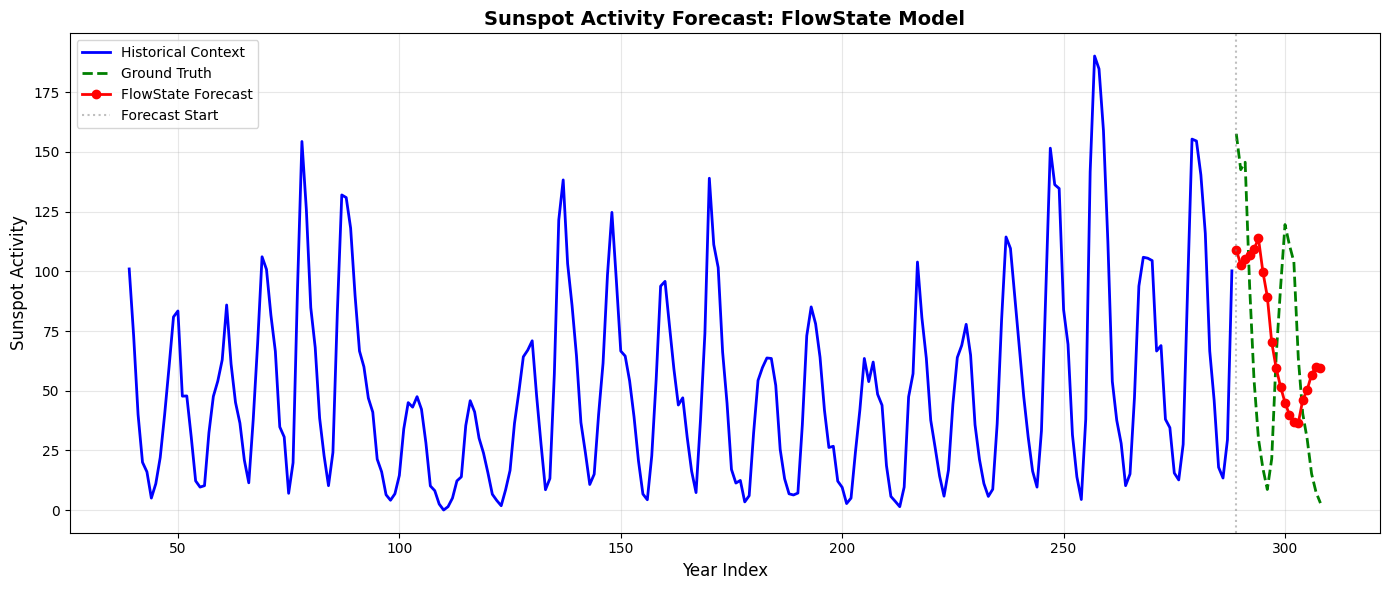

In [112]:
# Plot forecast vs ground truth
plt.figure(figsize=(14, 6))

# Historical data (context) - last 100 years before forecast
historical_start = len(sunspots) - context_length - horizon
plt.plot(
    range(historical_start, historical_start + context_length),
    sunspots[-context_length - horizon : -horizon],
    label="Historical Context",
    color="blue",
    linewidth=2,
)

# Ground truth (actual future values - last 10 years)
plt.plot(
    range(historical_start + context_length, historical_start + context_length + horizon),
    y_true,
    label="Ground Truth",
    color="green",
    linewidth=2,
    linestyle="--",
)

# Predictions
plt.plot(
    range(historical_start + context_length, historical_start + context_length + horizon),
    predictions,
    label="FlowState Forecast",
    color="red",
    linewidth=2,
    marker="o",
)

# Formatting
plt.axvline(x=historical_start + context_length, color="gray", linestyle=":", alpha=0.5, label="Forecast Start")
plt.title("Sunspot Activity Forecast: FlowState Model", fontsize=14, fontweight="bold")
plt.xlabel("Year Index", fontsize=12)
plt.ylabel("Sunspot Activity", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Evaluate Forecast Accuracy

In [98]:
# Calculate error metrics
mae = np.mean(np.abs(predictions - y_true))
rmse = np.sqrt(np.mean((predictions - y_true) ** 2))
mape = np.mean(np.abs((predictions - y_true) / (y_true + 1e-8))) * 100  # Add small epsilon to avoid division by zero

print("Forecast Accuracy Metrics:")
print(f"  MAE (Mean Absolute Error):        {mae:.2f}")
print(f"  RMSE (Root Mean Squared Error):   {rmse:.2f}")
print(f"  MAPE (Mean Absolute % Error):     {mape:.2f}%")

# Show point-by-point comparison
comparison_df = pd.DataFrame(
    {
        "Year": range(1, horizon + 1),
        "Ground Truth": y_true,
        "Predicted": predictions,
        "Error": predictions - y_true,
        "Abs Error": np.abs(predictions - y_true),
        "Error %": np.abs((predictions - y_true) / (y_true + 1e-8)) * 100,
    }
)

print("\nPoint-by-point comparison:")
print(comparison_df.to_string(index=False))

Forecast Accuracy Metrics:
  MAE (Mean Absolute Error):        46.54
  RMSE (Root Mean Squared Error):   52.50
  MAPE (Mean Absolute % Error):     247.58%

Point-by-point comparison:
 Year  Ground Truth  Predicted      Error  Abs Error     Error %
    1    157.600006 110.111465 -47.488541  47.488541   30.132320
    2    142.600006 101.707108 -40.892899  40.892899   28.676647
    3    145.699997 105.807846 -39.892151  39.892151   27.379650
    4     94.300003 103.392349   9.092346   9.092346    9.641936
    5     54.599998 104.626190  50.026192  50.026192   91.623062
    6     29.900000 108.711746  78.811745  78.811745  263.584412
    7     17.500000  95.563759  78.063759  78.063759  446.078644
    8      8.600000  84.107971  75.507973  75.507973  877.999695
    9     21.500000  64.489044  42.989044  42.989044  199.949036
   10     64.300003  54.203220 -10.096783  10.096783   15.702616
   11     93.300003  45.573807 -47.726196  47.726196   51.153477
   12    119.599998  39.152603 -80.44

## 9. Cleanup

In [99]:
# Close the client connection
# client.close()
# print("✓ Client connection closed")

## Next Steps

Try experimenting with:
- Different `context_length` values
- Different `horizon` values
- Different `scale_factor` for normalization
- The ToTo model with `ToToForecastRequest` for probabilistic forecasts
- Multiple time series in a batch (increase batch_size dimension)